In [1]:
import pandas as pd
import numpy as np
from operator import itemgetter

import pymorphy2 
import gensim

from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os

### Загрузка данных для тестирования моделей

In [25]:
data = pd.read_csv('./data/hj.csv')

In [59]:
data[data['word1']=='начало']

,word1,word2
220,начало,матч
369,начало,год


In [49]:
print normal_analizer.norm('начать')

начинать_VERB


In [28]:
y = data['sim'].values
data = data.drop(['sim'], axis=1)

### Определение части речи при помощи Pymorphy2

In [64]:
class NormalAnalyzer:
    __stemmer = pymorphy2.MorphAnalyzer()
    __cache = {}
    
    __grammars = {'NOUN': '_NOUN',
                'VERB': '_VERB', 'INFN': '_VERB', 'GRND': '_VERB', 'PRTF': '_VERB', 'PRTS': '_VERB',
                'ADJF': '_ADJ', 'ADJS': '_ADJ',
                'ADVB': '_ADV'}
    
    __grammars_keys = __grammars.keys()
    
    def norm(self, token):
        token = token.strip().decode('utf-8')
        
        norm = ''
        if token not in self.__cache:
            
            if token == u'джин':
                self.__cache[token] = u'джин_NOUN'
                return u'джин_NOUN'
            elif token == u'планета':
                self.__cache[token] = u'планета_NOUN'
                return u'планета_NOUN'
            elif token == u'дурдом':
                self.__cache[token] = u'дурдом_NOUN'
                return u'дурдом_NOUN'
            elif token == u'начало':
                self.__cache[token] = u'начало_NOUN'
                return u'начало_NOUN'
            elif token == u'подписать':
                self.__cache[token] = u'подписывать_VERB'
                return u'подписывать_VERB'
            elif token == u'заключенный':
                self.__cache[token] = u'заключенный_ADJ'
                return u'заключенный_ADJ'
    
            res = self.__stemmer.parse(token)
            list_POS = [form.tag.POS for form in res]
            res = res[0]
            norm = res.normal_form.replace(u'ё', u'е').replace('c', u'с')
            if 'NUMR' in list_POS:
                norm = norm + '_' + 'NUM'
            elif res.tag.POS in self.__grammars_keys:
                norm = norm + self.__grammars[res.tag.POS]
            else: 
                norm = norm + '_' + 'UNKN'
            self.__cache[token] = norm
        else :
            norm = self.__cache[token]
        return norm
    
normal_analizer = NormalAnalyzer()

In [62]:
def clean_word(word):
    return word.split('_')[0]

### Подсчет расхождений полученных предсказаний и значений данного датасета

Используемые метрики:
$$MSE=\frac{1}{n}\sum_{i=1}^{n}({predict}_{i}-y_i)^{2}$$

$$SpearmanrCorrelation=1-\frac{\sum_{}^{} d^2}{n(n^2 - 1)}$$
<p><center>где $d$ - сумма квадратов разностей рангов, $n$ - число парных наблюдений </center>

In [12]:
# __ Предварительная нормализация полученных списков результатов __
def accuracy_norm(predict, y):
    predict = (predict - min(predict)) / (max(predict) - min(predict))
    y = y / max(y)
    return mean_squared_error(predict, y)

In [13]:
def accuracy(predict, y):
    return mean_squared_error(predict, y)

### Некоторые функции печати

In [14]:
# __ Печать списка ненайденных пар __
def print_undefined(undefinded):
    if len(undefinded) != 0:
        print "Список ненайденных пар:\n"
        for words in undefinded:
            print clean_word(words[0]) + ' - ' + clean_word(words[1])
    print '\nВсего не найдено: %d' %len(undefinded)

In [15]:
# __ Печать ошибки по используемой метрике MSE __
def print_accuracy(predict, y):
    print "Нормализованные предсказания: "
    print accuracy_norm(predict, y) 
    print 
    print "Абсолютные предсказания: "
    print accuracy(predict, y) 
    print
    print "Spearman rank correlation: "
    print spearmanr(predict, y).correlation

### Функции для тестирования

In [16]:
# __ По массиву значений возвращает список позиций в упорядоченном массиве __
def position_in_ordered_list(array):
    array_index = zip(array, range(len(array)))
    sorted_array_index = sorted(array_index, key=itemgetter(0), reverse=True)
    return np.array(zip(*sorted_array_index)[1])

In [17]:
# __ Предсказания данных (data) моделью (model) __
# ____ Output: predict - список предсказаний
#              undefinded - список объектов, которые невозможно предсказать 

def predict(model, data):
    predict = []
    undefinded = []
    for item in data.values:
        word1 = normal_analizer.norm(item[0])
        word2 = normal_analizer.norm(item[1])
        try:
            predict.append(model.similarity(word1, word2))
        except:
            undefinded.append([word1, word2])
            predict.append(0)
    return predict, undefinded

In [18]:
# __ Построение графиков: гистограмма по MSE, 
#                         гистограмма по абсолютной ошибке 
# __

def plot_graphs(predict, y):
    param_weight = 0.4
    param_bins_MSE = np.arange(0, 0.4, 0.025)
    param_bins_Absolute= 40
    param_alpha = 0.65
    
    errors = np.array(predict - y)

    f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.hist(errors**2, bins=param_bins_MSE + 0.02 / 2, alpha=param_alpha, edgecolor='black', color='g', rwidth=param_weight, label='Absolute')
    ax1.axvline((errors**2).mean(), color='y', linestyle='dashed', linewidth=2, label='Absolute mean')
    ax1.set_xlabel('MSE', fontsize=20)
    ax1.set_ylabel('Number of objects', fontsize=20)
    # ax1.set_title('')
    
    variance_position = abs(position_in_ordered_list(predict) - position_in_ordered_list(y))
    ax2.hist(variance_position, bins=param_bins_Absolute, alpha=param_alpha, edgecolor='black', color='g')
    ax2.axvline(variance_position.mean(), color='y', linestyle='dashed', linewidth=2, label='Variance rank-order mean')
    ax2.set_xlabel('Variance rank-order', fontsize=20)
    
#     ax2.hist(errors, bins=param_bins_Absolute, alpha=param_alpha, edgecolor='black', color='g', label='Absolute')
#     ax2.axvline(errors.mean(), color='y', linestyle='dashed', linewidth=2, label='Absolute mean')
#     ax2.set_xlabel('Absolute error', fontsize=20)

    predict = (predict - min(predict)) / (max(predict) - min(predict))
    y = y / max(y)
    errors = np.array(predict - y)
    
    ax1.hist(errors**2, bins=param_bins_MSE, alpha=param_alpha, edgecolor='black', rwidth=param_weight, label='Normalized')
    ax1.axvline((errors**2).mean(), color='r', linestyle='dashed', linewidth=2, label='Normalized mean')
    
#     ax2.hist(errors, bins=param_bins_Absolute, alpha=param_alpha, edgecolor='black', label='Normalized')
#     ax2.axvline(errors.mean(), color='r', linestyle='dashed', linewidth=2, label='Normalized mean')

    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20) 

    

    plt.show()

### Тестирование моделей Word2Vec

#### Модель №1

Используется word2vec, обученный на **Национальном Корпусе Русского Языка** от "января 2017". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 250 миллионов слов |
| Частотный порог | 10 |
| Алгоритм | Skip-gram |
| Размерность вектора | 300 |
| Размер окна | 10 |

In [19]:
model = gensim.models.KeyedVectors.load_word2vec_format('./ruscorpora.bin', binary=True)

In [67]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)
print len(undefinded)

2


In [68]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.040152472329

Абсолютные предсказания: 
0.0367998209608

Spearman rank correlation: 
0.68503439607


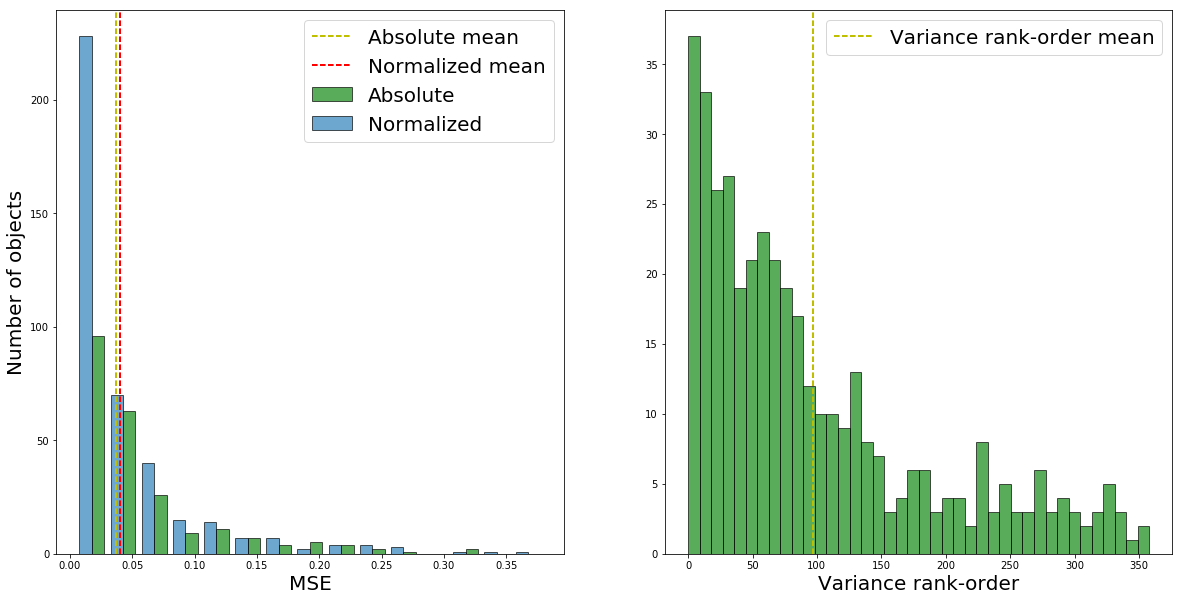

In [69]:
plot_graphs(predicts, y)

#### Модель №2

Используется word2vec, обученный на **Национальном Корпусе Русского Языка и Википедии** от "января 2017". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 600 миллионов слов |
| Частотный порог | 15 |
| Алгоритм | CBOW |
| Размерность вектора | 300 |
| Размер окна | 20 |

In [70]:
model = gensim.models.KeyedVectors.load_word2vec_format('./ruwikiruscorpora.bin', binary=True)

In [75]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)
print len(undefinded)

2


In [76]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0411610078923

Абсолютные предсказания: 
0.0509819300554

Spearman rank correlation: 
0.641340046202


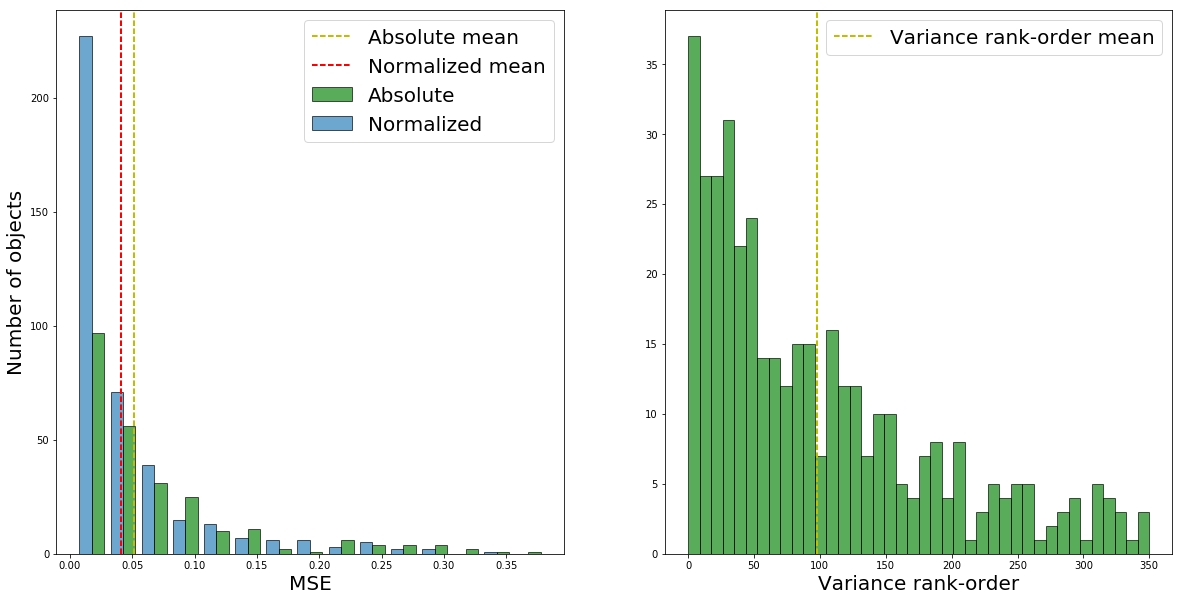

In [77]:
plot_graphs(predicts, y)

#### Модель №3

Используется word2vec, обученный на **Веб-корпусе** от "декабрь 2017". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 900 миллионов слов |
| Частотный порог | 30 |
| Алгоритм | CBOW |
| Размерность вектора | 300 |
| Размер окна | 20 |

In [78]:
model = gensim.models.KeyedVectors.load_word2vec_format('./web.bin', binary=True)

In [79]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)
print len(undefinded)

2


In [80]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0400544907362

Абсолютные предсказания: 
0.0539420002041

Spearman rank correlation: 
0.641116495043


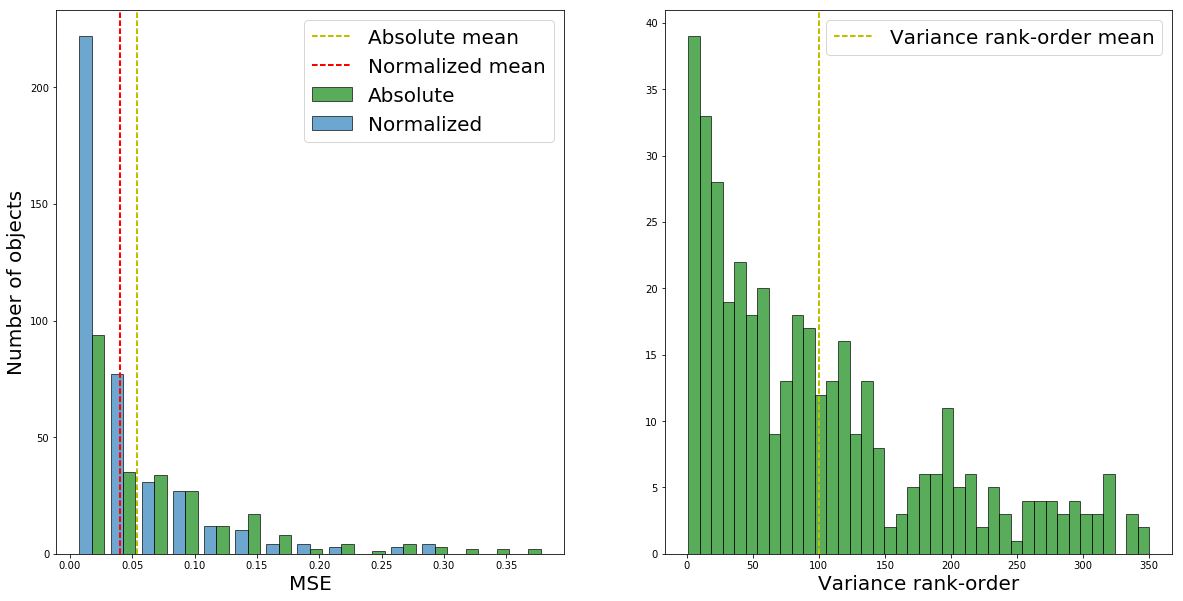

In [81]:
plot_graphs(predicts, y)

#### Модель №4

Используется word2vec, обученный на **Новостном корпусе** от "с сентября 2013 до ноября 2016". 

| Параметр | Значение |       
| :- |:- |
| Объем словаря | 5 миллиардов слов |
| Частотный порог | 200 |
| Алгоритм | CBOW |
| Размерность вектора | 300 |
| Размер окна | 2 |

In [82]:
model = gensim.models.KeyedVectors.load_word2vec_format('./news.bin', binary=True)

In [86]:
#  __ Предсказания первой модели близости пар нашего датасета __
predicts, undefinded = predict(model, data)

# __ Вывод ненайденных пар __
# print_undefined(undefinded)
print len(undefinded)

2


In [87]:
# __ Оцениваем близость предсказаний по размеченным данным __
print_accuracy(predicts, y)

Нормализованные предсказания: 
0.0489090111169

Абсолютные предсказания: 
0.0727769463928

Spearman rank correlation: 
0.589919280802


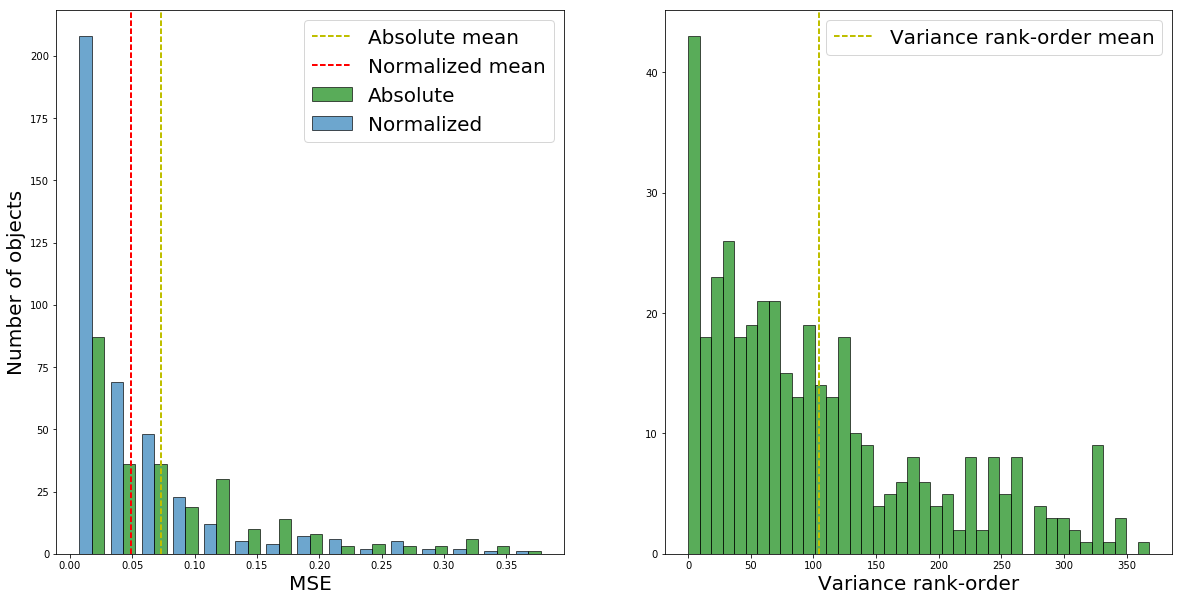

In [88]:
plot_graphs(predicts, y)

### Выводы по использованию различных готовых корпусов word2ec

|Корпус|Объем словаря|Частотный порог|Алгоритм|Размерность вектора|Размер окна|MSE + нормализация|MSE|Корреляция Спирмена|Кол-во ненайденных пар|
| :-: | :-: |:-: |:-: |:-: |:-: | :-: | :-: | :-: | :-: |
| НКРЯ | 250 миллионов слов | 10 | Skip-gramm | 300 | 10 | 0.04015 | 0.03680 | 0.68503 | 2 |
| Wiki | 600 миллионов слов | 15 | CBOW | 300 | 20 | 0.04116 | 0.05098 | 0.68503 | 2 |
| Web | 900 миллионов слов | 30 | CBOW | 300 | 20 | 0.04005 | 0.05394 | 0.64112 | 2 |
| News | 5 миллиардов слов | 200 | CBOW | 300 | 2 | 0.04891 | 0.07278 | 0.58992 | 2 |

1. Основным критерием качесва мы выберем коэффициент ранговой корреляции Спирмена, так как главной целью нашего предсказания является ранжирование пар по семантической близости. Наилучший результат показал национальный корпус русского языка, наихудший - новостной.
<p>
<p>
2. Если смотреть на отклонения от значений, то можно сказать, что нормализация предсказаний дает сильное улучшение на большинстве корпусах. Это логично, так как одна максимально синонимичная пара, не входящая в тестовый датасет, уменьшает значения схожести другим парам. 
<p>
<p>
3. Опираясь на количество ненайденных пар, можно сделать вывод, что использование новостного корпуса не лучшая идея. Высокий частотный порог news (на порядок больше других корпусов) выбрасывает весомую часть нашей тестовой выборки из свого словаря и, как следствие, не может предсказать их семантическую близость.
<p>
<p>
4. На данный момент мы не можем сказать, насколько сильно влияет выбор алгоритма (CBOW и Skip-gramm), размер окна и размер вектора, так как нет сравнений конкретно по каждому параметру, ипользуя один корпус.
<p>
<p>
5. И на последок, word2vec неплохо справляется со своей задачей. Постараемся улучшить качество, используя дополненительно  словари Тезаурус

### Тест

In [81]:
!mystem

/bin/sh: mystem: command not found


In [47]:
try:
    model.most_similar(u'год_NOUN')
except:
    print "Не найдено"

In [247]:
normal_analizer.norm('сто')

u'\u0441\u0442\u043e_NUM'